# Post-IMSC : Compare results for 2022 and 2023 as target year


To do:
- figure out why 2022 and 2023 give such different nAHD results - Ok, resolved.
- Summary results/figs for different metrics

Other/elsewhere
- update population to new
- check coherence obs/models and get CI/significance levels on shift fit (see Coles & other stats books, write to Clair). Possibly consider effect of aerosols. Read Vautard's new paper on linear shift of temperatures. 

In [2]:
# necessary: netcdf4-python, regionmask, (xarray, geopandas), cartopy, openpyxl, statsmodels

import numpy as np
import pandas as pd
import os, glob, re 
import math
import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import dask
import matplotlib.pyplot as plt
import netCDF4

%matplotlib inline

#plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# import my variables settings functions from other scripts
from settings import *

# import fxns 
from functions import *
from utils import *
from plotscript import *

# import other packages/modules 

sys.path.append('../population/') # TODO: update to new dem4cli ! w new SSP2 pop data! 
from population_demographics_climate import * # move / rename this when good ! --> change to import demographics4climate as d4c


# sys.path.append('../../../demographics4climate/')
# from population_demographics import * 



In [3]:
from dask.distributed import Client 
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 60.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35207,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 60.00 GiB
Comm: tcp://127.0.0.1:37257,Total threads: 1
Dashboard: http://127.0.0.1:44665/status,Memory: 30.00 GiB
Nanny: tcp://127.0.0.1:33423,


In [4]:
figdir = os.path.join(figdirs, 'fig_jun24-imsc')


# 00. Plotting and reporting functions (finalize+move from here)

In [5]:
# model mean and range (not IQR)

def plot_barplot_n_prop_people_atleastx_modelmean(da, 
                                                  unit, 
                                                  ax, 
                                                  year=2022, 
                                                  proportion=False, 
                                                  x_hot_days = [1,5,10,20,50],
                                                 legend=True,
                                                 errcolor='gray',
                                                 color=None,
                                                 title=True):
    # plot range 
    if unit == 1e9:
        unit_str = 'billions'
    elif unit == 1e6:
        unit_str='millions'
    else:
        unit_str = ''

    upper_error = (da.max(dim='model')-da.mean(dim='model')).values.T /unit
    lower_error = (da.mean(dim='model')-da.min(dim='model')).values.T /unit
    try:
        concatenated =np.concatenate((lower_error,upper_error), axis=1)
        reshaped = np.reshape(concatenated, (len(da.features), 2, len(da.age_ranges)))
    except:
        concatenated =np.concatenate((lower_error,upper_error))
        reshaped = np.reshape(concatenated, (2, len(da.age_ranges)))

    # plot multi-model mean 
    if color == None:
        (da.mean(dim='model')/unit).to_pandas().plot.bar(ax=ax,
                                                   yerr=reshaped,
                                                   error_kw=dict(ecolor=errcolor, alpha=1, elinewidth=.8, capsize=1))
    else:
        (da.mean(dim='model')/unit).to_pandas().plot.bar(ax=ax,
                                                   yerr=reshaped,
                                                         color=color,
                                                   error_kw=dict(ecolor=errcolor, alpha=1, elinewidth=.8, capsize=1))        
                          
    if proportion ==False:
        ax.set_ylabel(f'Number of people ({unit_str})')
        if title==True:
            ax.set_title(f'number of people experiencing at least n attributable hot days in {year}')
    else:
        ax.set_ylabel(f'Proportion of age group (%)')
        if title ==True:
            ax.set_title(f'proportion of age group experiencing at least n attributable hot days in {year}')
    
    ax.set_xlabel('Ages')
    step_ages = int(da.age_ranges[1] -da.age_ranges[0] - 1)
    ax.set_xticks(ticks=ax.get_xticks(), labels=[f'{x}-{x+step_ages}' for x in da.age_ranges.values],  rotation=45) #'horizontal'
    if legend==True:
        ax.legend(labels = [f'at least {x}' for x in x_hot_days])

In [6]:
def plot_percapitadays_median_iqr(da, feature, ax):
    
    df_plot =  da.sel(features=feature).to_pandas()
    
    medianprops = dict(color='k',linewidth=2)
    whiskerprops = dict(color='none')
    capprops = dict(color='none')

    plot = ax.boxplot(df_plot,  
                      whiskerprops=whiskerprops, 
                      capprops=capprops, 
                      medianprops=medianprops,
                      patch_artist=True,
                      showfliers=False) #boxprops=boxprops,

    col='cadetblue'
    for patch in plot['boxes']:
            patch.set_facecolor(col)
            patch.set_edgecolor(col)

    ax.set_xticks(ticks=ax.get_xticks(), labels=[f'{x}-{x+9}' for x in df_plot.columns], rotation=45);
    plt.ylabel('Per capita attributable \nhot-humid days per year')
    plt.xlabel('Ages');

In [7]:
def df_summary_mean_range(da,feature,units):
    
    if units > 100:
        df_summary = da.sel(features=feature).to_pandas().T / units
    elif units == 100:
        df_summary = da.sel(features=feature).to_pandas().T * units
    elif units == None:
         df_summary = da.sel(features=feature).to_pandas().T
    df_summary['mean'] = df_summary.iloc[:,0:6].mean(axis=1)
    df_summary['min'] = df_summary.iloc[:,0:6].min(axis=1)
    df_summary['max'] = df_summary.iloc[:,0:6].max(axis=1)
    df_summary = df_summary.astype(float)
    
    return df_summary.round(decimals=1)


def df_summary_median_iqr(da,feature,units=None):
    df_summary = da.sel(features=feature).to_pandas().T
    df_summary['median'] = df_summary.iloc[:,0:6].median(axis=1)
    df_summary['Q1'] = df_summary.iloc[:,0:6].quantile(0.25,axis=1)
    df_summary['Q3'] = df_summary.iloc[:,0:6].quantile(0.75,axis=1)
    df_summary = df_summary.astype(float)

    return df_summary.round(decimals=1)
    

# 0. Population preprocessing

To do : update to new !!! 

In [8]:
d_countries = preprocess_all_country_population_data()
gs_population_global = get_gridscale_population_global( 
    d_countries,
    startyear=2023,
    endyear=None,
    save=False # change where this gets saved !!!! now its in package folder
)

interpolating cohort sizes per country
after interpolation and mean-preserving correction there are some neg numbers in 10, Azerbaijan, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 98, Libya, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 136, Papua New Guinea, setting them to zero
Aruba small, population not calculated
Antigua and Barbuda small, population not calculated
Bahrain small, population not calculated
Barbados small, population not calculated
Federated States of Micronesia small, population not calculated
Grenada small, population not calculated
Guam small, population not calculated
Saint Lucia small, population not calculated
Macao small, population not calculated
Maldives small, population not calculated
Malta small, population not calculated
Singapore small, population not calculated
Tonga small, population not calculated
calculating gridscale population per cou

# 1. GCMs: nAHD using empirical percentiles of 30-year periods

In [9]:
dirname='output_empirical'
models='ISIMIP3b'

# open for 2022
year=2022

da_nAHD_WBGT28_2022 = open_all_nAHD(GCMs,  metric='WBGT28', outdirname=dirname, year_pres=year) # see here i coded what models it is in the fxn 
da_nAHD_WBGT30_2022 = open_all_nAHD(GCMs,  metric='WBGT30', outdirname=dirname, year_pres=year)
da_nAHD_WBGT33_2022 = open_all_nAHD(GCMs,  metric='WBGT33', outdirname=dirname, year_pres=year)

#da_nAHD_WBGT90_2022 = open_all_nAHD(GCMs,  metric='WBGT90', outdirname=dirname, year_pres=year) # dont have these for 2022 - caclculate them 
#da_nAHD_WBGT95_2022 = open_all_nAHD(GCMs,  metric='WBGT95', outdirname=dirname, year_pres=year) 
da_nAHD_WBGT99_2022 = open_all_nAHD(GCMs,  metric='WBGT99', outdirname=dirname, year_pres=year) 

da_nAHD_TX90_2022 = open_all_nAHD(GCMs,  metric='TX90', outdirname=dirname, year_pres=year) 
da_nAHD_TX95_2022 = open_all_nAHD(GCMs,  metric='TX95', outdirname=dirname, year_pres=year)  
da_nAHD_TX99_2022 = open_all_nAHD(GCMs,  metric='TX99', outdirname=dirname, year_pres=year) 




# open for 2023
year=2023

da_nAHD_WBGT28_2023 = open_all_nAHD(GCMs,  metric='WBGT28', outdirname=dirname, year_pres=year) # see here i coded what models it is in the fxn 
da_nAHD_WBGT30_2023 = open_all_nAHD(GCMs,  metric='WBGT30', outdirname=dirname, year_pres=year)
da_nAHD_WBGT33_2023 = open_all_nAHD(GCMs,  metric='WBGT33', outdirname=dirname, year_pres=year)

da_nAHD_WBGT90_2023 = open_all_nAHD(GCMs,  metric='WBGT90', outdirname=dirname, year_pres=year) # dont have these for 2022
da_nAHD_WBGT95_2023 = open_all_nAHD(GCMs,  metric='WBGT95', outdirname=dirname, year_pres=year) 
da_nAHD_WBGT99_2023 = open_all_nAHD(GCMs,  metric='WBGT99', outdirname=dirname, year_pres=year) 

da_nAHD_TX90_2023 = open_all_nAHD(GCMs,  metric='TX90', outdirname=dirname, year_pres=year) 
da_nAHD_TX95_2023 = open_all_nAHD(GCMs,  metric='TX95', outdirname=dirname, year_pres=year)  
da_nAHD_TX99_2023 = open_all_nAHD(GCMs,  metric='TX99', outdirname=dirname, year_pres=year) 


## 1a. WBGT28

### demographic result (2022)

In [8]:
# 2022 

da_nAHD = da_nAHD_WBGT28_2022

da_n_people_ndays, da_prop_people_ndays = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

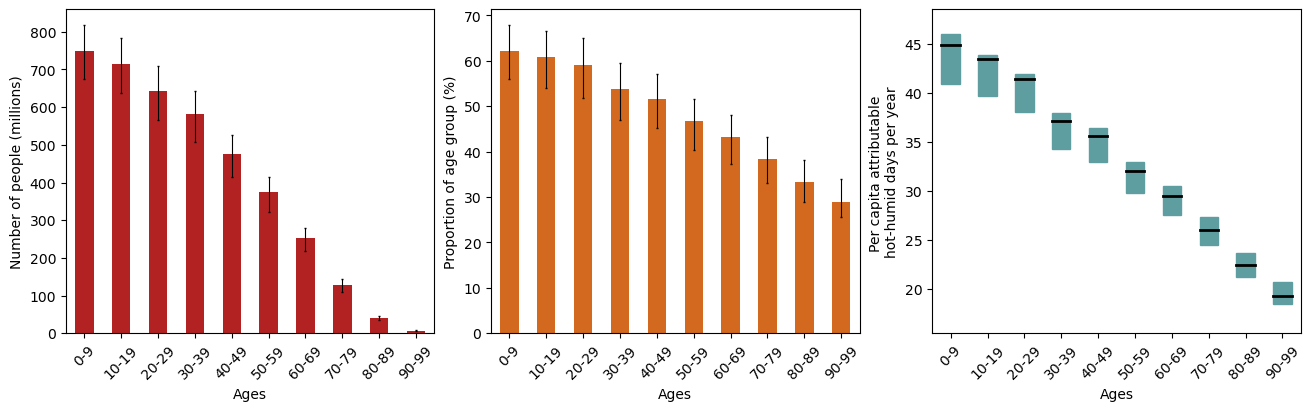

In [9]:
fig,axes=plt.subplots(1,3,figsize=(13,4),layout='constrained')

#[ax.tick_params(axis='both', which='major', labelsize=10) for ax in axes]

ax=axes[0]
plot_barplot_n_prop_people_atleastx_modelmean(da_n_people_ndays.sel(features='n_atleast_20'), 
                                              unit=1e6,  
                                              ax=ax, 
                                              proportion=False, 
                                              legend=False,
                                              errcolor='k',
                                              color='firebrick',
                                              title=False)

ax=axes[1]
plot_barplot_n_prop_people_atleastx_modelmean(da_prop_people_ndays.sel(features='prop_atleast_20') * 100, 
                                              unit=1,  
                                              ax=ax, 
                                              proportion=True, 
                                              legend=False,
                                              errcolor='k',
                                              color='chocolate',
                                              title=False)

ax=axes[2]
plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y,
                              feature='per_capita_days',
                              ax=ax)

In [42]:
#print('number of people n at least 20\n',df_summary_mean_range(da_n_people_ndays,'n_atleast_20',1e6)[['mean','min','max']])
#print('prop of people\n',df_summary_mean_range(da_prop_people_ndays, feature='prop_atleast_20',units=100)[['mean','min','max']])
#print('per capita\n',df_summary_median_iqr(da_nAHD_percapita_peopledays_10y, feature='per_capita_days').iloc[:,-3:])

In [11]:
# get summary RATIO 0-9 versus 60-69 

# here: first calc ratio 0-9 versus 60-69 then take MMM 

print('Ratio number of people exposed 0-9 v. 60-69')

d = (da_n_people_ndays.sel(age_ranges=0) / da_n_people_ndays.sel(age_ranges=60)).to_pandas().T
dmin, dmax, dmean = d.min(axis=1), d.max(axis=1), d.mean(axis=1)
pd.DataFrame([dmean,dmin,dmax],index=['mean','min','max']).T.round(2)


# work on this ! Calculating slopes/ number for each age comparison 


Ratio number of people exposed 0-9 v. 60-69


,mean,min,max
features,,,
n_atleast_1,2.23,2.20,2.27
n_atleast_5,2.36,2.32,2.41
n_atleast_10,2.52,2.45,2.62
n_atleast_20,2.98,2.87,3.14
n_atleast_50,3.73,3.38,4.20


In [12]:
print('Ratio proportion of age group exposed 0-9 v. 60-69')

d = (da_prop_people_ndays.sel(age_ranges=0) / da_prop_people_ndays.sel(age_ranges=60)).to_pandas().T
dmin, dmax, dmean = d.min(axis=1), d.max(axis=1), d.mean(axis=1)
pd.DataFrame([dmean,dmin,dmax],index=['mean','min','max']).T.round(2)


Ratio proportion of age group exposed 0-9 v. 60-69


,mean,min,max
features,,,
prop_atleast_1,1.08,1.07,1.10
prop_atleast_5,1.14,1.12,1.17
prop_atleast_10,1.22,1.19,1.27
prop_atleast_20,1.44,1.39,1.52
prop_atleast_50,1.81,1.64,2.04


In [13]:
d = (da_nAHD_percapita_peopledays_10y.sel(features='per_capita_days',age_ranges=0) / da_nAHD_percapita_peopledays_10y.sel(features='per_capita_days',age_ranges=60)).to_pandas()
pd.DataFrame([d.mean(),d.min(),d.max()],index=['mean','min','max'],columns=['per_cap']).T.round(2)


,mean,min,max
per_cap,1.49,1.42,1.62


### different year (2023)

In [14]:
# 2023

da_nAHD = da_nAHD_WBGT28_2023

da_n_people_ndays, da_prop_people_ndays = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

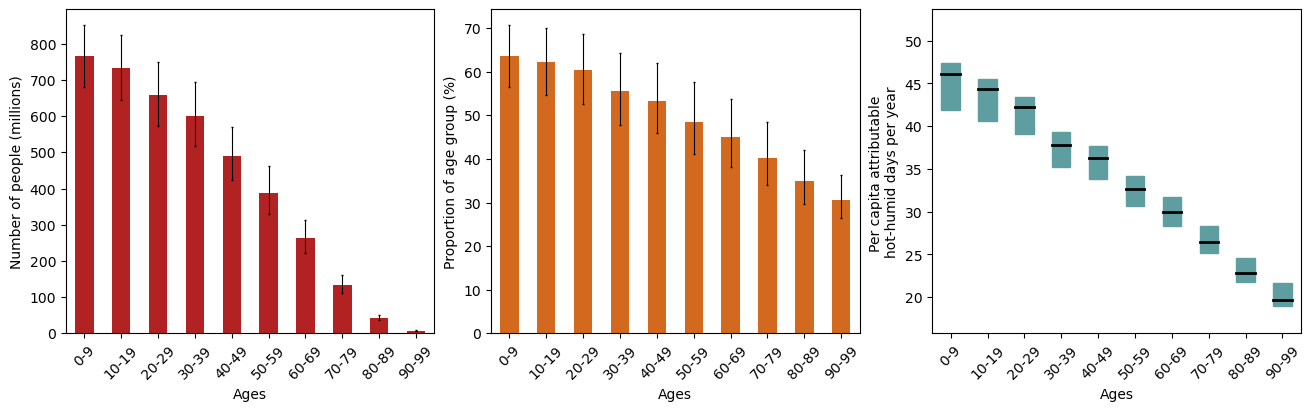

In [15]:
fig,axes=plt.subplots(1,3,figsize=(13,4),layout='constrained')

#[ax.tick_params(axis='both', which='major', labelsize=10) for ax in axes]

ax=axes[0]
plot_barplot_n_prop_people_atleastx_modelmean(da_n_people_ndays.sel(features='n_atleast_20'), 
                                              unit=1e6,  
                                              ax=ax, 
                                              proportion=False, 
                                              legend=False,
                                              errcolor='k',
                                              color='firebrick',
                                              title=False)

ax=axes[1]
plot_barplot_n_prop_people_atleastx_modelmean(da_prop_people_ndays.sel(features='prop_atleast_20') * 100, 
                                              unit=1,  
                                              ax=ax, 
                                              proportion=True, 
                                              legend=False,
                                              errcolor='k',
                                              color='chocolate',
                                              title=False)

ax=axes[2]
plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y,
                              feature='per_capita_days',
                              ax=ax)

In [16]:
#df_summary_mean_range(da_n_people_ndays,'n_atleast_20',1e6)

In [17]:
# get summary RATIO 0-9 versus 60-69 

# here: first calc ratio 0-9 versus 60-69 then take MMM 

print('Ratio number of people exposed 0-9 v. 60-69')

d = (da_n_people_ndays.sel(age_ranges=0) / da_n_people_ndays.sel(age_ranges=60)).to_pandas().T
dmin, dmax, dmean = d.min(axis=1), d.max(axis=1), d.mean(axis=1)
pd.DataFrame([dmean,dmin,dmax],index=['mean','min','max']).T.round(2)


# work on this ! Calculating slopes/ number for each age comparison 


Ratio number of people exposed 0-9 v. 60-69


,mean,min,max
features,,,
n_atleast_1,2.22,2.19,2.25
n_atleast_5,2.34,2.30,2.39
n_atleast_10,2.50,2.42,2.61
n_atleast_20,2.94,2.72,3.12
n_atleast_50,3.71,3.30,4.19


In [18]:
print('Ratio proportion of age group exposed 0-9 v. 60-69')

d = (da_prop_people_ndays.sel(age_ranges=0) / da_prop_people_ndays.sel(age_ranges=60)).to_pandas().T
dmin, dmax, dmean = d.min(axis=1), d.max(axis=1), d.mean(axis=1)
pd.DataFrame([dmean,dmin,dmax],index=['mean','min','max']).T.round(2)


Ratio proportion of age group exposed 0-9 v. 60-69


,mean,min,max
features,,,
prop_atleast_1,1.08,1.06,1.09
prop_atleast_5,1.14,1.12,1.16
prop_atleast_10,1.21,1.17,1.27
prop_atleast_20,1.42,1.32,1.51
prop_atleast_50,1.80,1.60,2.03


In [19]:
d = (da_nAHD_percapita_peopledays_10y.sel(features='per_capita_days',age_ranges=0) / da_nAHD_percapita_peopledays_10y.sel(features='per_capita_days',age_ranges=60)).to_pandas()
pd.DataFrame([d.mean(),d.min(),d.max()],index=['mean','min','max'],columns=['per_cap']).T.round(2)


,mean,min,max
per_cap,1.48,1.41,1.62


### compare maps : very similar ! 

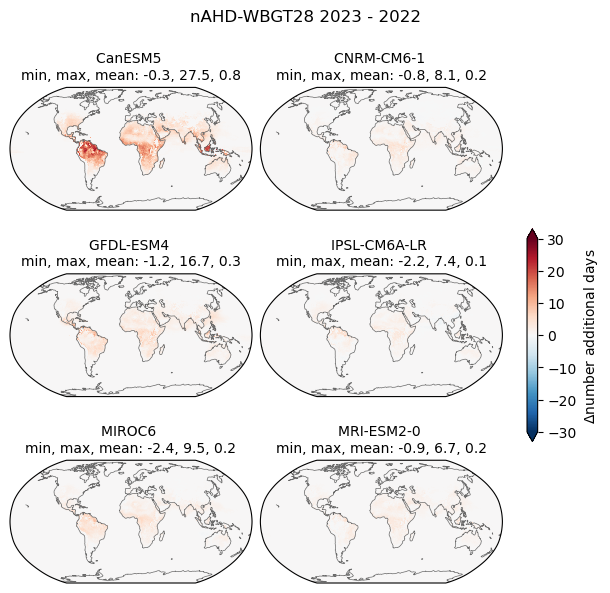

In [22]:
da_nAHD = da_nAHD_WBGT28_2023 - da_nAHD_WBGT28_2022

proj = ccrs.Robinson()
landmask = get_mask()
crs = ccrs.PlateCarree()
vmax = 30
levels = np.linspace(-vmax,vmax,num=20)

fig, axes = plt.subplots(3,2,figsize=(6,6), subplot_kw={'projection': proj},layout='constrained')
axes = axes.flatten() 

for GCM, ax in zip(GCMs, axes):
    data_plot = da_nAHD.sel(model=GCM) #*landmask
    plot = data_plot.plot(ax=ax, cmap = 'RdBu_r', vmax=vmax, vmin=-vmax, transform=crs, add_colorbar=False) 
    ax.set_title(f'{GCM} \nmin, max, mean: {data_plot.min():.1f}, {data_plot.max():.1f}, {data_plot.mean():.1f}',size=10)
    ax.coastlines(color='dimgray', linewidth=0.5)

plt.colorbar(plot, extend='both',ax=axes.ravel().tolist(),shrink=.4,label='$\Delta$number additional days')
fig.suptitle(f'nAHD-WBGT28 2023 - 2022\n');


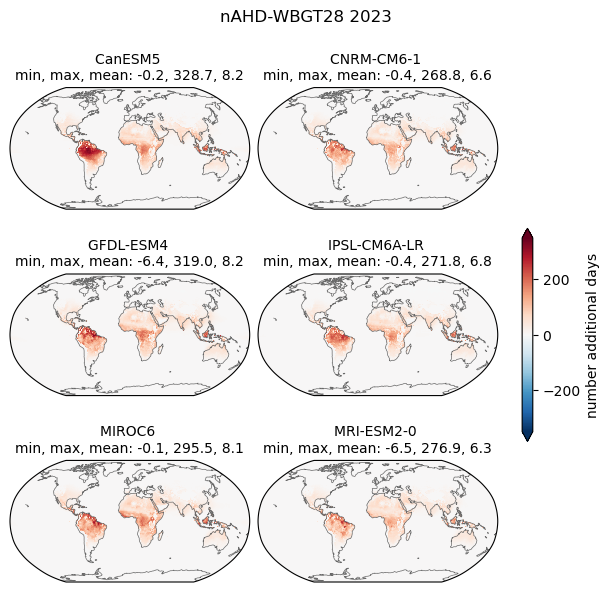

In [27]:
da_nAHD = da_nAHD_WBGT28_2023

proj = ccrs.Robinson()
landmask = get_mask()
crs = ccrs.PlateCarree()
vmax = 350
levels = np.linspace(-vmax,vmax,num=20)

fig, axes = plt.subplots(3,2,figsize=(6,6), subplot_kw={'projection': proj},layout='constrained')
axes = axes.flatten() 

for GCM, ax in zip(GCMs, axes):
    data_plot = da_nAHD.sel(model=GCM) #*landmask
    plot = data_plot.plot(ax=ax, cmap = 'RdBu_r', vmax=vmax, vmin=-vmax, transform=crs, add_colorbar=False) 
    ax.set_title(f'{GCM} \nmin, max, mean: {data_plot.min():.1f}, {data_plot.max():.1f}, {data_plot.mean():.1f}',size=10)
    ax.coastlines(color='dimgray', linewidth=0.5)

plt.colorbar(plot, extend='both',ax=axes.ravel().tolist(),shrink=.4,label='number additional days')
fig.suptitle(f'nAHD-WBGT28 2023\n');

## 1b. TX99

### compare maps : ok, issue resolved

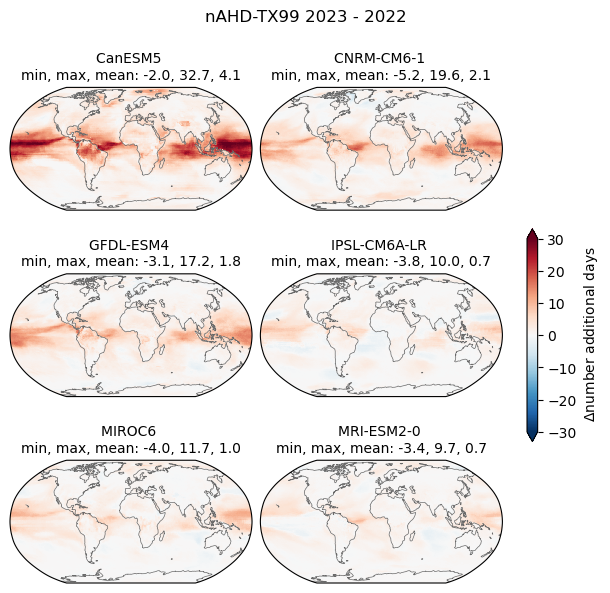

In [21]:
da_nAHD = da_nAHD_TX99_2023 - da_nAHD_TX99_2022

proj = ccrs.Robinson()
landmask = get_mask()
crs = ccrs.PlateCarree()
vmax = 30
levels = np.linspace(-vmax,vmax,num=20)


fig, axes = plt.subplots(3,2,figsize=(6,6), subplot_kw={'projection': proj},layout='constrained')
axes = axes.flatten() 

for GCM, ax in zip(GCMs, axes):
    data_plot = da_nAHD.sel(model=GCM) #*landmask
    plot = data_plot.plot(ax=ax, cmap = 'RdBu_r', vmax=vmax, vmin=-vmax, transform=crs, add_colorbar=False) 
    ax.set_title(f'{GCM} \nmin, max, mean: {data_plot.min():.1f}, {data_plot.max():.1f}, {data_plot.mean():.1f}',size=10)
    ax.coastlines(color='dimgray', linewidth=0.5)

plt.colorbar(plot, extend='both',ax=axes.ravel().tolist(),shrink=.4,label=' $\Delta$number additional days')
fig.suptitle(f'nAHD-TX99 2023 - 2022\n');

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


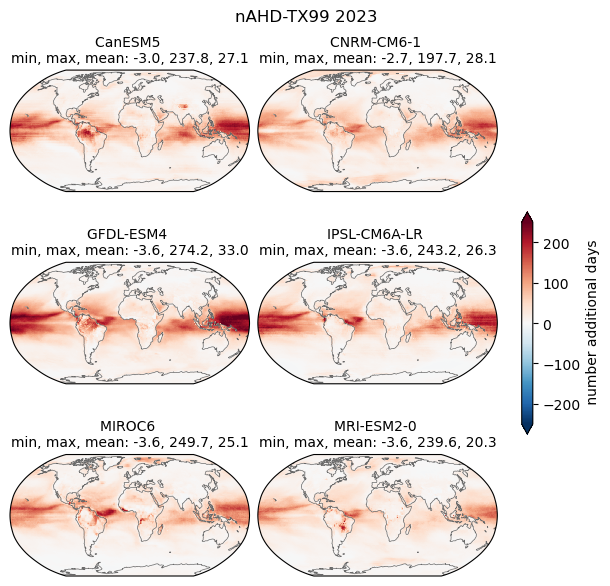

In [29]:
da_nAHD = da_nAHD_TX99_2023

proj = ccrs.Robinson()
landmask = get_mask()
crs = ccrs.PlateCarree()
vmax = 250
levels = np.linspace(-vmax,vmax,num=20)


fig, axes = plt.subplots(3,2,figsize=(6,6), subplot_kw={'projection': proj},layout='constrained')
axes = axes.flatten() 

for GCM, ax in zip(GCMs, axes):
    data_plot = da_nAHD.sel(model=GCM) #*landmask
    plot = data_plot.plot(ax=ax, cmap = 'RdBu_r', vmax=vmax, vmin=-vmax, transform=crs, add_colorbar=False) 
    ax.set_title(f'{GCM} \nmin, max, mean: {data_plot.min():.1f}, {data_plot.max():.1f}, {data_plot.mean():.1f}',size=10)
    ax.coastlines(color='dimgray', linewidth=0.5)

plt.colorbar(plot, extend='both',ax=axes.ravel().tolist(),shrink=.4,label=' number additional days')
fig.suptitle(f'nAHD-TX99 2023');

### demographic results for 2023

In [31]:
# 2023

da_nAHD = da_nAHD_TX99_2023

da_n_people_ndays, da_prop_people_ndays = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

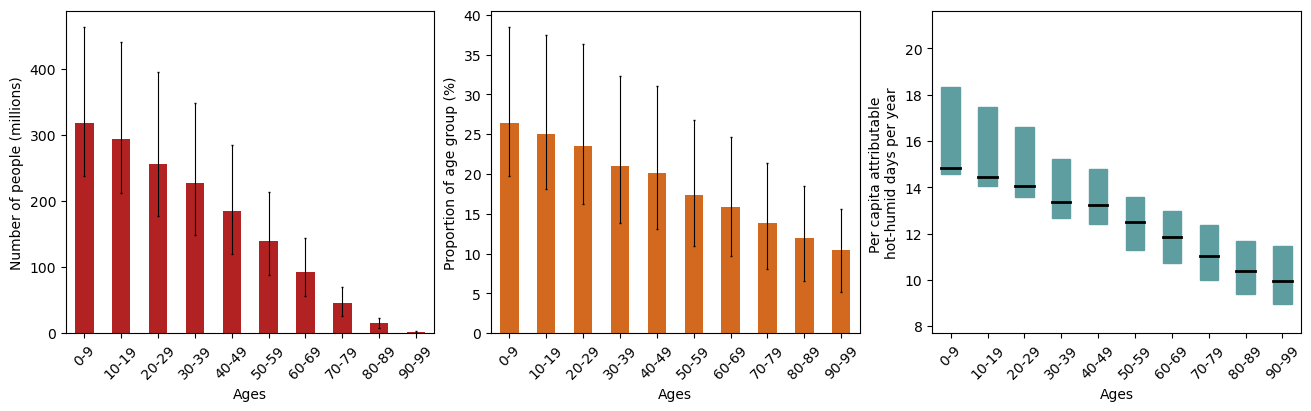

In [32]:
fig,axes=plt.subplots(1,3,figsize=(13,4),layout='constrained')

#[ax.tick_params(axis='both', which='major', labelsize=10) for ax in axes]

ax=axes[0]
plot_barplot_n_prop_people_atleastx_modelmean(da_n_people_ndays.sel(features='n_atleast_20'), 
                                              unit=1e6,  
                                              ax=ax, 
                                              proportion=False, 
                                              legend=False,
                                              errcolor='k',
                                              color='firebrick',
                                              title=False)

ax=axes[1]
plot_barplot_n_prop_people_atleastx_modelmean(da_prop_people_ndays.sel(features='prop_atleast_20') * 100, 
                                              unit=1,  
                                              ax=ax, 
                                              proportion=True, 
                                              legend=False,
                                              errcolor='k',
                                              color='chocolate',
                                              title=False)

ax=axes[2]
plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y,
                              feature='per_capita_days',
                              ax=ax)

In [33]:
#df_summary_mean_range(da_n_people_ndays,'n_atleast_20',1e6)

In [34]:
# get summary RATIO 0-9 versus 60-69 

# here: first calc ratio 0-9 versus 60-69 then take MMM 

print('Ratio number of people exposed 0-9 v. 60-69')

d = (da_n_people_ndays.sel(age_ranges=0) / da_n_people_ndays.sel(age_ranges=60)).to_pandas().T
dmin, dmax, dmean = d.min(axis=1), d.max(axis=1), d.mean(axis=1)
pd.DataFrame([dmean,dmin,dmax],index=['mean','min','max']).T.round(2)


# work on this ! Calculating slopes/ number for each age comparison 


Ratio number of people exposed 0-9 v. 60-69


,mean,min,max
features,,,
n_atleast_1,2.08,2.01,2.17
n_atleast_5,2.38,2.11,2.59
n_atleast_10,2.94,2.38,3.26
n_atleast_20,3.54,2.80,4.20
n_atleast_50,2.94,2.42,4.07


In [35]:
print('Ratio proportion of age group exposed 0-9 v. 60-69')

d = (da_prop_people_ndays.sel(age_ranges=0) / da_prop_people_ndays.sel(age_ranges=60)).to_pandas().T
dmin, dmax, dmean = d.min(axis=1), d.max(axis=1), d.mean(axis=1)
pd.DataFrame([dmean,dmin,dmax],index=['mean','min','max']).T.round(2)


Ratio proportion of age group exposed 0-9 v. 60-69


,mean,min,max
features,,,
prop_atleast_1,1.01,0.97,1.05
prop_atleast_5,1.15,1.02,1.26
prop_atleast_10,1.43,1.15,1.58
prop_atleast_20,1.72,1.36,2.04
prop_atleast_50,1.43,1.18,1.98


In [36]:
d = (da_nAHD_percapita_peopledays_10y.sel(features='per_capita_days',age_ranges=0) / da_nAHD_percapita_peopledays_10y.sel(features='per_capita_days',age_ranges=60)).to_pandas()
pd.DataFrame([d.mean(),d.min(),d.max()],index=['mean','min','max'],columns=['per_cap']).T.round(2)


,mean,min,max
per_cap,1.34,1.15,1.52


## 2a. WBGT30, WBGT33

### WBGT30

In [10]:
da_nAHD = da_nAHD_WBGT30_2023

da_n_people_ndays, da_prop_people_ndays = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

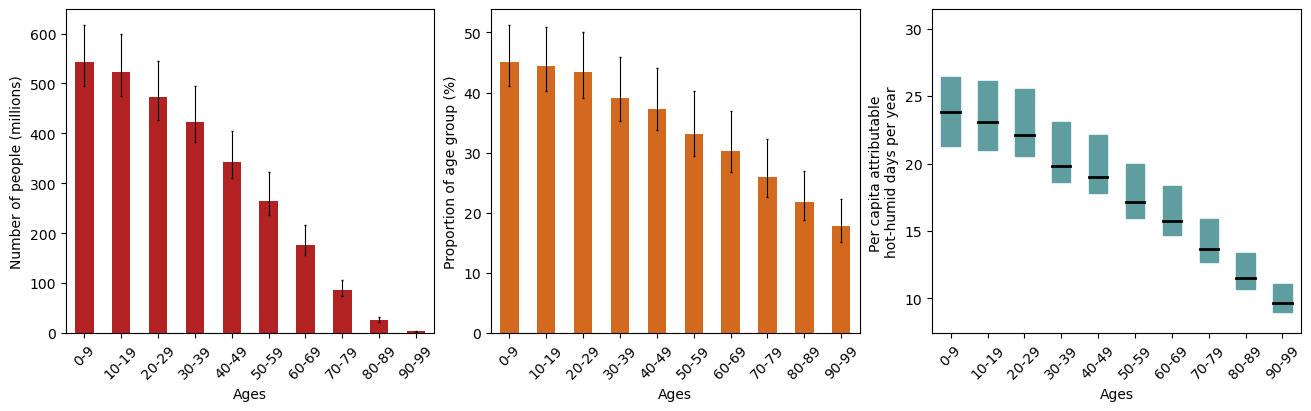

In [11]:
fig,axes=plt.subplots(1,3,figsize=(13,4),layout='constrained')

#[ax.tick_params(axis='both', which='major', labelsize=10) for ax in axes]

ax=axes[0]
plot_barplot_n_prop_people_atleastx_modelmean(da_n_people_ndays.sel(features='n_atleast_20'), 
                                              unit=1e6,  
                                              ax=ax, 
                                              proportion=False, 
                                              legend=False,
                                              errcolor='k',
                                              color='firebrick',
                                              title=False)

ax=axes[1]
plot_barplot_n_prop_people_atleastx_modelmean(da_prop_people_ndays.sel(features='prop_atleast_20') * 100, 
                                              unit=1,  
                                              ax=ax, 
                                              proportion=True, 
                                              legend=False,
                                              errcolor='k',
                                              color='chocolate',
                                              title=False)

ax=axes[2]
plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y,
                              feature='per_capita_days',
                              ax=ax)

In [12]:
#print('number of people n at least 20\n',df_summary_mean_range(da_n_people_ndays,'n_atleast_20',1e6)[['mean','min','max']])
#print('prop of people\n',df_summary_mean_range(da_prop_people_ndays, feature='prop_atleast_20',units=100)[['mean','min','max']])
#print('per capita\n',df_summary_median_iqr(da_nAHD_percapita_peopledays_10y, feature='per_capita_days').iloc[:,-3:])

In [13]:
# get summary RATIO 0-9 versus 60-69 

# here: first calc ratio 0-9 versus 60-69 then take MMM 

print('Ratio number of people exposed 0-9 v. 60-69')

d = (da_n_people_ndays.sel(age_ranges=0) / da_n_people_ndays.sel(age_ranges=60)).to_pandas().T
dmin, dmax, dmean = d.min(axis=1), d.max(axis=1), d.mean(axis=1)
pd.DataFrame([dmean,dmin,dmax],index=['mean','min','max']).T.round(2)


# work on this ! Calculating slopes/ number for each age comparison 


Ratio number of people exposed 0-9 v. 60-69


,mean,min,max
features,,,
n_atleast_1,2.34,2.31,2.40
n_atleast_5,2.51,2.42,2.61
n_atleast_10,2.73,2.51,2.89
n_atleast_20,3.07,2.86,3.24
n_atleast_50,3.71,3.27,4.73


In [14]:
print('Ratio proportion of age group exposed 0-9 v. 60-69')

d = (da_prop_people_ndays.sel(age_ranges=0) / da_prop_people_ndays.sel(age_ranges=60)).to_pandas().T
dmin, dmax, dmean = d.min(axis=1), d.max(axis=1), d.mean(axis=1)
pd.DataFrame([dmean,dmin,dmax],index=['mean','min','max']).T.round(2)


Ratio proportion of age group exposed 0-9 v. 60-69


,mean,min,max
features,,,
prop_atleast_1,1.13,1.12,1.16
prop_atleast_5,1.22,1.17,1.26
prop_atleast_10,1.32,1.22,1.40
prop_atleast_20,1.49,1.39,1.57
prop_atleast_50,1.80,1.59,2.29


In [15]:
d = (da_nAHD_percapita_peopledays_10y.sel(features='per_capita_days',age_ranges=0) / da_nAHD_percapita_peopledays_10y.sel(features='per_capita_days',age_ranges=60)).to_pandas()
pd.DataFrame([d.mean(),d.min(),d.max()],index=['mean','min','max'],columns=['per_cap']).T.round(2)


,mean,min,max
per_cap,1.45,1.39,1.58


### WBGT33

In [16]:
da_nAHD = da_nAHD_WBGT33_2023

da_n_people_ndays, da_prop_people_ndays = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

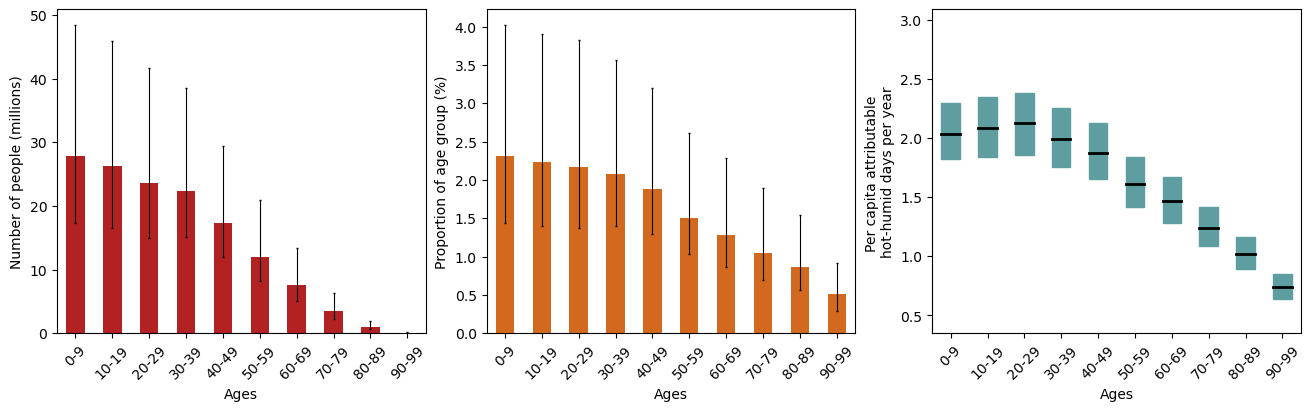

In [17]:
fig,axes=plt.subplots(1,3,figsize=(13,4),layout='constrained')

#[ax.tick_params(axis='both', which='major', labelsize=10) for ax in axes]

ax=axes[0]
plot_barplot_n_prop_people_atleastx_modelmean(da_n_people_ndays.sel(features='n_atleast_20'), 
                                              unit=1e6,  
                                              ax=ax, 
                                              proportion=False, 
                                              legend=False,
                                              errcolor='k',
                                              color='firebrick',
                                              title=False)

ax=axes[1]
plot_barplot_n_prop_people_atleastx_modelmean(da_prop_people_ndays.sel(features='prop_atleast_20') * 100, 
                                              unit=1,  
                                              ax=ax, 
                                              proportion=True, 
                                              legend=False,
                                              errcolor='k',
                                              color='chocolate',
                                              title=False)

ax=axes[2]
plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y,
                              feature='per_capita_days',
                              ax=ax)

In [18]:
# get summary RATIO 0-9 versus 60-69 

# here: first calc ratio 0-9 versus 60-69 then take MMM 

print('Ratio number of people exposed 0-9 v. 60-69')

d = (da_n_people_ndays.sel(age_ranges=0) / da_n_people_ndays.sel(age_ranges=60)).to_pandas().T
dmin, dmax, dmean = d.min(axis=1), d.max(axis=1), d.mean(axis=1)
pd.DataFrame([dmean,dmin,dmax],index=['mean','min','max']).T.round(2)


# work on this ! Calculating slopes/ number for each age comparison 


Ratio number of people exposed 0-9 v. 60-69


,mean,min,max
features,,,
n_atleast_1,2.55,2.44,2.67
n_atleast_5,2.90,2.86,3.00
n_atleast_10,3.13,2.94,3.41
n_atleast_20,3.72,3.42,4.16
n_atleast_50,4.28,3.62,4.77


In [19]:
print('Ratio proportion of age group exposed 0-9 v. 60-69')

d = (da_prop_people_ndays.sel(age_ranges=0) / da_prop_people_ndays.sel(age_ranges=60)).to_pandas().T
dmin, dmax, dmean = d.min(axis=1), d.max(axis=1), d.mean(axis=1)
pd.DataFrame([dmean,dmin,dmax],index=['mean','min','max']).T.round(2)


Ratio proportion of age group exposed 0-9 v. 60-69


,mean,min,max
features,,,
prop_atleast_1,1.24,1.18,1.29
prop_atleast_5,1.41,1.39,1.46
prop_atleast_10,1.52,1.42,1.65
prop_atleast_20,1.81,1.66,2.02
prop_atleast_50,2.07,1.75,2.32


In [20]:
d = (da_nAHD_percapita_peopledays_10y.sel(features='per_capita_days',age_ranges=0) / da_nAHD_percapita_peopledays_10y.sel(features='per_capita_days',age_ranges=60)).to_pandas()
pd.DataFrame([d.mean(),d.min(),d.max()],index=['mean','min','max'],columns=['per_cap']).T.round(2)


,mean,min,max
per_cap,1.43,1.37,1.54


## 2b. TX90, TX95

### TX90

In [21]:
da_nAHD = da_nAHD_TX90_2023

da_n_people_ndays, da_prop_people_ndays = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

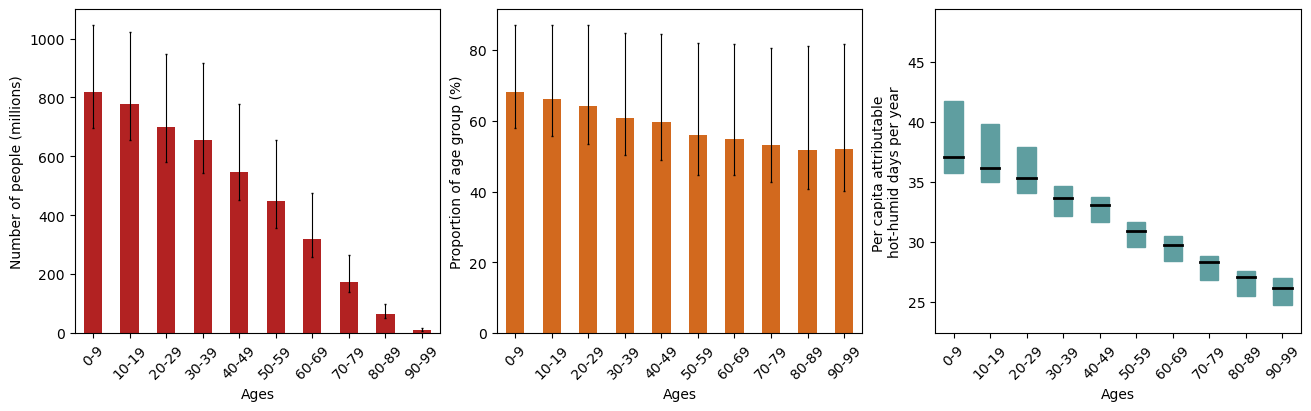

In [22]:
fig,axes=plt.subplots(1,3,figsize=(13,4),layout='constrained')

#[ax.tick_params(axis='both', which='major', labelsize=10) for ax in axes]

ax=axes[0]
plot_barplot_n_prop_people_atleastx_modelmean(da_n_people_ndays.sel(features='n_atleast_20'), 
                                              unit=1e6,  
                                              ax=ax, 
                                              proportion=False, 
                                              legend=False,
                                              errcolor='k',
                                              color='firebrick',
                                              title=False)

ax=axes[1]
plot_barplot_n_prop_people_atleastx_modelmean(da_prop_people_ndays.sel(features='prop_atleast_20') * 100, 
                                              unit=1,  
                                              ax=ax, 
                                              proportion=True, 
                                              legend=False,
                                              errcolor='k',
                                              color='chocolate',
                                              title=False)

ax=axes[2]
plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y,
                              feature='per_capita_days',
                              ax=ax)

In [23]:
# get summary RATIO 0-9 versus 60-69 

# here: first calc ratio 0-9 versus 60-69 then take MMM 

print('Ratio number of people exposed 0-9 v. 60-69')

d = (da_n_people_ndays.sel(age_ranges=0) / da_n_people_ndays.sel(age_ranges=60)).to_pandas().T
dmin, dmax, dmean = d.min(axis=1), d.max(axis=1), d.mean(axis=1)
pd.DataFrame([dmean,dmin,dmax],index=['mean','min','max']).T.round(2)


# work on this ! Calculating slopes/ number for each age comparison 


Ratio number of people exposed 0-9 v. 60-69


,mean,min,max
features,,,
n_atleast_1,2.04,2.02,2.06
n_atleast_5,2.06,2.03,2.10
n_atleast_10,2.12,2.07,2.23
n_atleast_20,2.60,2.20,2.82
n_atleast_50,3.49,3.00,3.98


In [24]:
print('Ratio proportion of age group exposed 0-9 v. 60-69')

d = (da_prop_people_ndays.sel(age_ranges=0) / da_prop_people_ndays.sel(age_ranges=60)).to_pandas().T
dmin, dmax, dmean = d.min(axis=1), d.max(axis=1), d.mean(axis=1)
pd.DataFrame([dmean,dmin,dmax],index=['mean','min','max']).T.round(2)


Ratio proportion of age group exposed 0-9 v. 60-69


,mean,min,max
features,,,
prop_atleast_1,0.99,0.98,1.00
prop_atleast_5,1.00,0.98,1.02
prop_atleast_10,1.03,1.00,1.08
prop_atleast_20,1.26,1.07,1.37
prop_atleast_50,1.70,1.45,1.93


In [25]:
d = (da_nAHD_percapita_peopledays_10y.sel(features='per_capita_days',age_ranges=0) / da_nAHD_percapita_peopledays_10y.sel(features='per_capita_days',age_ranges=60)).to_pandas()
pd.DataFrame([d.mean(),d.min(),d.max()],index=['mean','min','max'],columns=['per_cap']).T.round(2)


,mean,min,max
per_cap,1.28,1.18,1.47


### TX95

In [26]:
da_nAHD = da_nAHD_TX95_2023

da_n_people_ndays, da_prop_people_ndays = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

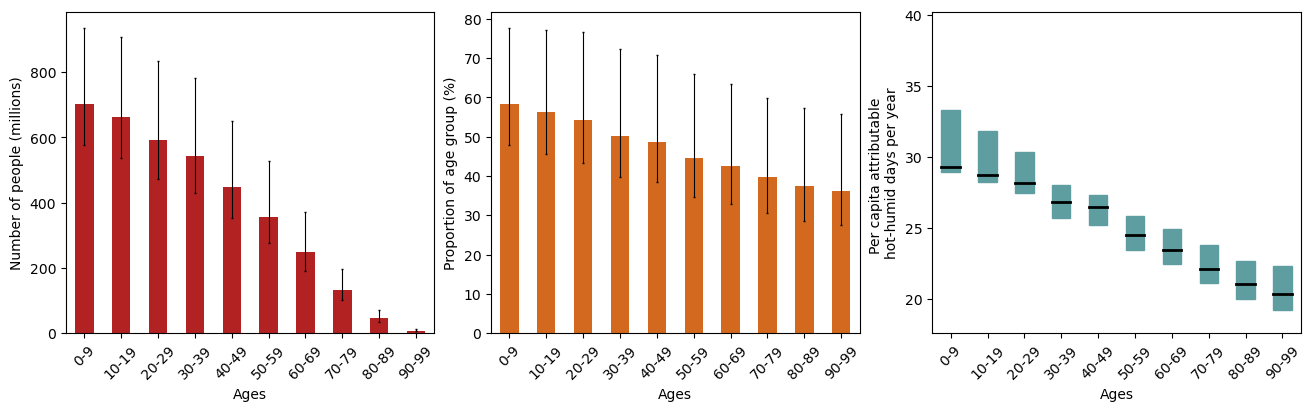

In [27]:
fig,axes=plt.subplots(1,3,figsize=(13,4),layout='constrained')

#[ax.tick_params(axis='both', which='major', labelsize=10) for ax in axes]

ax=axes[0]
plot_barplot_n_prop_people_atleastx_modelmean(da_n_people_ndays.sel(features='n_atleast_20'), 
                                              unit=1e6,  
                                              ax=ax, 
                                              proportion=False, 
                                              legend=False,
                                              errcolor='k',
                                              color='firebrick',
                                              title=False)

ax=axes[1]
plot_barplot_n_prop_people_atleastx_modelmean(da_prop_people_ndays.sel(features='prop_atleast_20') * 100, 
                                              unit=1,  
                                              ax=ax, 
                                              proportion=True, 
                                              legend=False,
                                              errcolor='k',
                                              color='chocolate',
                                              title=False)

ax=axes[2]
plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y,
                              feature='per_capita_days',
                              ax=ax)

In [28]:
# get summary RATIO 0-9 versus 60-69 

# here: first calc ratio 0-9 versus 60-69 then take MMM 

print('Ratio number of people exposed 0-9 v. 60-69')

d = (da_n_people_ndays.sel(age_ranges=0) / da_n_people_ndays.sel(age_ranges=60)).to_pandas().T
dmin, dmax, dmean = d.min(axis=1), d.max(axis=1), d.mean(axis=1)
pd.DataFrame([dmean,dmin,dmax],index=['mean','min','max']).T.round(2)


# work on this ! Calculating slopes/ number for each age comparison 


Ratio number of people exposed 0-9 v. 60-69


,mean,min,max
features,,,
n_atleast_1,2.05,2.01,2.10
n_atleast_5,2.08,2.03,2.15
n_atleast_10,2.25,2.13,2.39
n_atleast_20,2.86,2.52,3.08
n_atleast_50,3.32,2.80,3.91


In [29]:
print('Ratio proportion of age group exposed 0-9 v. 60-69')

d = (da_prop_people_ndays.sel(age_ranges=0) / da_prop_people_ndays.sel(age_ranges=60)).to_pandas().T
dmin, dmax, dmean = d.min(axis=1), d.max(axis=1), d.mean(axis=1)
pd.DataFrame([dmean,dmin,dmax],index=['mean','min','max']).T.round(2)


Ratio proportion of age group exposed 0-9 v. 60-69


,mean,min,max
features,,,
prop_atleast_1,1.00,0.98,1.02
prop_atleast_5,1.01,0.99,1.05
prop_atleast_10,1.09,1.03,1.16
prop_atleast_20,1.39,1.22,1.50
prop_atleast_50,1.61,1.36,1.90


In [30]:
d = (da_nAHD_percapita_peopledays_10y.sel(features='per_capita_days',age_ranges=0) / da_nAHD_percapita_peopledays_10y.sel(features='per_capita_days',age_ranges=60)).to_pandas()
pd.DataFrame([d.mean(),d.min(),d.max()],index=['mean','min','max'],columns=['per_cap']).T.round(2)


,mean,min,max
per_cap,1.28,1.16,1.45


## 2c. WBGT90, WBGT95, WBGT99

### WBGT90

In [31]:
da_nAHD = da_nAHD_WBGT90_2023

da_n_people_ndays, da_prop_people_ndays = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

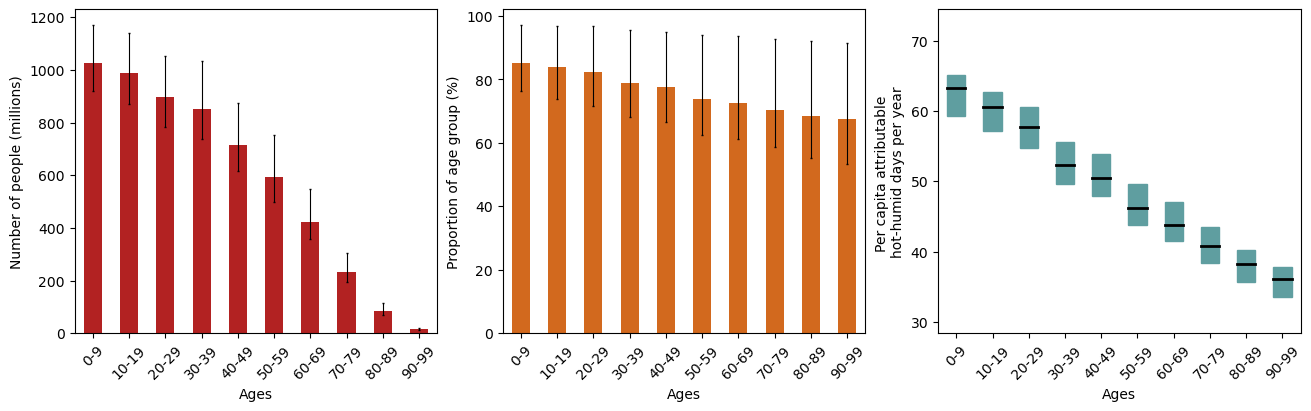

In [32]:
fig,axes=plt.subplots(1,3,figsize=(13,4),layout='constrained')

#[ax.tick_params(axis='both', which='major', labelsize=10) for ax in axes]

ax=axes[0]
plot_barplot_n_prop_people_atleastx_modelmean(da_n_people_ndays.sel(features='n_atleast_20'), 
                                              unit=1e6,  
                                              ax=ax, 
                                              proportion=False, 
                                              legend=False,
                                              errcolor='k',
                                              color='firebrick',
                                              title=False)

ax=axes[1]
plot_barplot_n_prop_people_atleastx_modelmean(da_prop_people_ndays.sel(features='prop_atleast_20') * 100, 
                                              unit=1,  
                                              ax=ax, 
                                              proportion=True, 
                                              legend=False,
                                              errcolor='k',
                                              color='chocolate',
                                              title=False)

ax=axes[2]
plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y,
                              feature='per_capita_days',
                              ax=ax)

In [33]:
# get summary RATIO 0-9 versus 60-69 

# here: first calc ratio 0-9 versus 60-69 then take MMM 

print('Ratio number of people exposed 0-9 v. 60-69')

d = (da_n_people_ndays.sel(age_ranges=0) / da_n_people_ndays.sel(age_ranges=60)).to_pandas().T
dmin, dmax, dmean = d.min(axis=1), d.max(axis=1), d.mean(axis=1)
pd.DataFrame([dmean,dmin,dmax],index=['mean','min','max']).T.round(2)


# work on this ! Calculating slopes/ number for each age comparison 


Ratio number of people exposed 0-9 v. 60-69


,mean,min,max
features,,,
n_atleast_1,2.06,2.05,2.06
n_atleast_5,2.06,2.05,2.06
n_atleast_10,2.08,2.06,2.09
n_atleast_20,2.45,2.14,2.71
n_atleast_50,3.83,3.46,4.21


In [34]:
print('Ratio proportion of age group exposed 0-9 v. 60-69')

d = (da_prop_people_ndays.sel(age_ranges=0) / da_prop_people_ndays.sel(age_ranges=60)).to_pandas().T
dmin, dmax, dmean = d.min(axis=1), d.max(axis=1), d.mean(axis=1)
pd.DataFrame([dmean,dmin,dmax],index=['mean','min','max']).T.round(2)


Ratio proportion of age group exposed 0-9 v. 60-69


,mean,min,max
features,,,
prop_atleast_1,1.00,1.00,1.00
prop_atleast_5,1.00,0.99,1.00
prop_atleast_10,1.01,1.00,1.01
prop_atleast_20,1.19,1.04,1.31
prop_atleast_50,1.86,1.68,2.04


In [35]:
d = (da_nAHD_percapita_peopledays_10y.sel(features='per_capita_days',age_ranges=0) / da_nAHD_percapita_peopledays_10y.sel(features='per_capita_days',age_ranges=60)).to_pandas()
pd.DataFrame([d.mean(),d.min(),d.max()],index=['mean','min','max'],columns=['per_cap']).T.round(2)


,mean,min,max
per_cap,1.4,1.32,1.53


### WBGT95

In [37]:
da_nAHD = da_nAHD_WBGT95_2023

da_n_people_ndays, da_prop_people_ndays = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

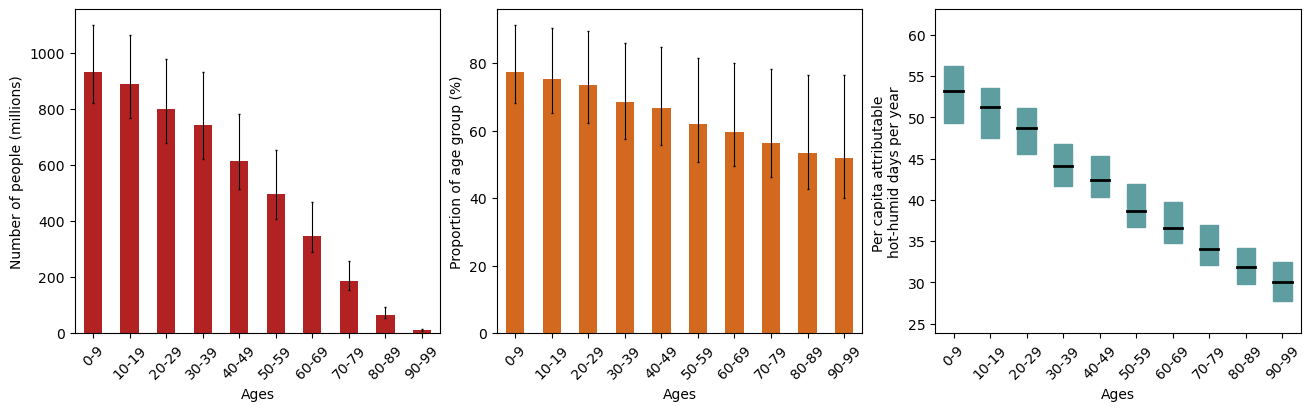

In [38]:
fig,axes=plt.subplots(1,3,figsize=(13,4),layout='constrained')

#[ax.tick_params(axis='both', which='major', labelsize=10) for ax in axes]

ax=axes[0]
plot_barplot_n_prop_people_atleastx_modelmean(da_n_people_ndays.sel(features='n_atleast_20'), 
                                              unit=1e6,  
                                              ax=ax, 
                                              proportion=False, 
                                              legend=False,
                                              errcolor='k',
                                              color='firebrick',
                                              title=False)

ax=axes[1]
plot_barplot_n_prop_people_atleastx_modelmean(da_prop_people_ndays.sel(features='prop_atleast_20') * 100, 
                                              unit=1,  
                                              ax=ax, 
                                              proportion=True, 
                                              legend=False,
                                              errcolor='k',
                                              color='chocolate',
                                              title=False)

ax=axes[2]
plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y,
                              feature='per_capita_days',
                              ax=ax)

In [39]:
# get summary RATIO 0-9 versus 60-69 

# here: first calc ratio 0-9 versus 60-69 then take MMM 

print('Ratio number of people exposed 0-9 v. 60-69')

d = (da_n_people_ndays.sel(age_ranges=0) / da_n_people_ndays.sel(age_ranges=60)).to_pandas().T
dmin, dmax, dmean = d.min(axis=1), d.max(axis=1), d.mean(axis=1)
pd.DataFrame([dmean,dmin,dmax],index=['mean','min','max']).T.round(2)


# work on this ! Calculating slopes/ number for each age comparison 


Ratio number of people exposed 0-9 v. 60-69


,mean,min,max
features,,,
n_atleast_1,2.06,2.04,2.06
n_atleast_5,2.06,2.03,2.06
n_atleast_10,2.14,2.06,2.30
n_atleast_20,2.71,2.35,2.88
n_atleast_50,3.99,3.58,4.26


In [40]:
print('Ratio proportion of age group exposed 0-9 v. 60-69')

d = (da_prop_people_ndays.sel(age_ranges=0) / da_prop_people_ndays.sel(age_ranges=60)).to_pandas().T
dmin, dmax, dmean = d.min(axis=1), d.max(axis=1), d.mean(axis=1)
pd.DataFrame([dmean,dmin,dmax],index=['mean','min','max']).T.round(2)


Ratio proportion of age group exposed 0-9 v. 60-69


,mean,min,max
features,,,
prop_atleast_1,1.00,0.99,1.00
prop_atleast_5,1.00,0.99,1.00
prop_atleast_10,1.04,1.00,1.11
prop_atleast_20,1.31,1.14,1.40
prop_atleast_50,1.94,1.74,2.07


In [41]:
d = (da_nAHD_percapita_peopledays_10y.sel(features='per_capita_days',age_ranges=0) / da_nAHD_percapita_peopledays_10y.sel(features='per_capita_days',age_ranges=60)).to_pandas()
pd.DataFrame([d.mean(),d.min(),d.max()],index=['mean','min','max'],columns=['per_cap']).T.round(2)


,mean,min,max
per_cap,1.4,1.31,1.56
